This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/pend.html).  I recommend having both windows open, side-by-side!


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    DiagramBuilder,
    LogVectorOutput,
    Simulator,
    StartMeshcat,
    SymbolicVectorSystem,
    Variable,
)

from underactuated.meshcat_utils import _interact

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Autapse

The simplest recurrent neural network model.  $$\dot{x} + x = \tanh(wx + u)$$

In [3]:
def autapse(x, w=1, u=0):
    """Args:
    w is feedback weight
    u is input
    """
    return -x + np.tanh(w * x + u)


Autapse = np.vectorize(autapse)
xmax = 2.0
ymax = 1.0
x = np.arange(-xmax, xmax, 0.01)

meshcat.Delete()
meshcat.Set2dRenderMode(xmax=xmax, xmin=-xmax, ymin=-ymax, ymax=ymax)
meshcat.SetProperty("/Grid", "visible", True)
meshcat.SetProperty("/Axes", "visible", True)


def update(w=1, u=0):
    # TODO(russt): Visualize fixed points here, too.
    meshcat.SetLine(
        "autapse", np.vstack([x, 0 * x, Autapse(x, w=w, u=u)]), line_width=4.0
    )


_interact(meshcat, update, w=(0, 3, 0.1), u=(-1.5, 1.5, 0.1))

Press the 'Stop Interacting' button in Meshcat to continue.


Now to capture the "bistability" of the autapse, let's simulate the system's response to an input wave with a square pulse.  From the initial conditions, it converges towards the stable fixed point near $x=1$, but when we set the input we move that fixed point (to closer to $x=-1$). But the "memory" persists; if we remove the input, it will stay in the new fixed point.

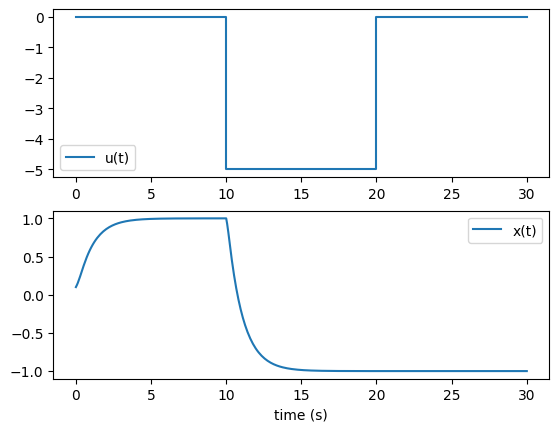

In [4]:
def pulse_response_demo():
    x = Variable("x")
    u = Variable("u")
    w = 5

    builder = DiagramBuilder()
    autapse = builder.AddSystem(
        SymbolicVectorSystem(
            state=[x],
            input=[u],
            dynamics=[-x + np.tanh(w * x + u)],
            output=[x],
        )
    )
    logger = LogVectorOutput(autapse.get_output_port(0), builder)
    builder.ExportInput(autapse.get_input_port(0))

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    # initial conditions: x = .1, u = 0
    context.SetContinuousState([0.1])
    diagram.get_input_port(0).FixValue(context, [0])

    simulator = Simulator(diagram, context)
    simulator.AdvanceTo(10)

    diagram.get_input_port(0).FixValue(context, [-5])
    simulator.AdvanceTo(20)

    diagram.get_input_port(0).FixValue(context, [0])
    simulator.AdvanceTo(30)

    log = logger.FindLog(context)
    fig, ax = plt.subplots(2, 1)
    ax[0].plot([0, 10, 10, 20, 20, 30], [0, 0, -5, -5, 0, 0])  # input
    ax[1].plot(log.sample_times(), log.data().T)  # state
    ax[0].legend(["u(t)"])
    ax[1].legend(["x(t)"])
    ax[1].set_xlabel("time (s)")


pulse_response_demo()